# Degree-day Calculator 

## Examples for using the phthon code

Calculates the thermokarst initiation likelihood based on chosen method which can be the climate priming method, as that is the only option at this point in time. A command line tool also exists. It works using the default parameters in many cases. To see its instructions run `python ddc/utility.py --help` at the command line.



### Imports

In [1]:
from ddc.calc_degree_days import calc_grid_degree_days, create_day_array, calc_degree_days
from ddc.multigrids import tools, TemporalGrid
import os, glob
import matplotlib.pyplot as plt
import gdal
import numpy as np

from multiprocessing import Manager
from datetime import datetime

### Loading Data

The data need to be loaded in to a special grid format, from multigrids. This gird type is a wraper around the numpy memmap functionality, and was devloped as the internal data representation format for atm project. All of the grid code is in the `muligrids` sub-pakage but the only functions needed to load the data are in `ddc.multigrids.tools`

#### Important functions and classes
- `ddc.TemporalGrid`:
    This class represnets a grid of data that changes with time
- `ddc.multigrids.tools.load_and_create`:
    This load the data from a directory containing tiff files
- `ddc.multigrids.tools.get_raster_metadata`:
    This loads the raster transform, and projection from a raster dataset

#### Load Monthly Temperature data

use the `ddc.multigrids.tools.load_and_create` function to load the monthly temperature data in to a MultiGrid.

##### Parameters
- load_params: dict
        parameters used to load the data from the tiff files. Keys are as follows:
        `directory`: path to the data.
        `method`: method for loading data. This must be "tiff" 
        `file_name_structure`: File expansion pattern used by `glob.glob` to find files to load. 
        Deafaults to '*.tif'
        `sort_func`: Function to sort files. Defaults to `sorted`
        `verbose`: If True, messages are printed describing the status of the loading data. Defautls to False
        
- create_params: dict
        Keyword paramters used in multigrid.TemporalGrid creation. Only the important keys for this process are 
        shown here, for other options see the `ddc.multigrids.tools.create` documentation. Keys are as follows:
        `name`: a name for the data set
        `start_timestep`: the start year for the data


##### Load Data

First caclulate the number of years from the number of monthly files, and create the grid names used to index the data in the grid.



In [2]:
path = "../data/V1/temperature/monthly/SP/v1/tiff/"

## calculate the number of years from the number of monthly files
start_year = 1901
months = [
    '01','02','03','04','05','06',
    '07','08','09','10','11','12',
]

num_years = len(
    glob.glob(os.path.join(path,'*.tif')) 
) 
num_years = num_years // 12

years = [start_year + yr for yr in range(num_years)]


temporal_grid_keys = [] 
for yr in years: 
    for mn in months: 
        temporal_grid_keys.append(str(yr) + '-' + str(mn)) 


load_params = {
    "directory": path,
    "method": "tiff",
    "file_name_structure": '*.tif',
    "sort_func": sorted, 
    "verbose": False
}

create_params = {
    "name": "Monthly Temperature",  
    "grid_names": temporal_grid_keys
}

temperature_data = tools.load_and_create(load_params, create_params)

##### Load the raster metadata


In [3]:
raster_file = glob.glob(os.path.join(path,'*.tif'))[0]
raster_metadata = tools.get_raster_metadata(raster_file)
temperature_data.config['raster_metadata'] = raster_metadata

##### Mask out missing data

In [4]:
mask_val = -9999

idx = temperature_data.grids == mask_val
temperature_data.grids[idx] = np.nan

#### Create Empty Degree-day gridss

In [5]:
# get the shape of the gridded data
grid_shape = temperature_data.config['grid_shape']

fdd_data = TemporalGrid(
    grid_shape[0], grid_shape[1], num_years, 
    start_timestep=start_year,
    dataset_name = 'fdd',
    mode='w+'
)
tdd_data = TemporalGrid(
    grid_shape[0], grid_shape[1], num_years, 
    start_timestep=start_year,
    dataset_name = 'tdd',
    mode='w+'
)

#### Create Array of Days

create an array of days since the start of the time period to use to create spline functions to caclulate the degree days. This can be done quickly using `ddc.calc_degree_days.create_day_array` whcih take an array of datatime objects and returns an array of days.

In [6]:
days = create_day_array( 
    [datetime.strptime(d, '%Y-%m') for d in temporal_grid_keys] 
)

#### Setup Logging

Use a `multiprocessing.Manager` object to create a shared dict that is used for logging by `ddc.calc_degree_days.calc_gird_degree_days`

Set `log['verbose']` to 0, 1, or 2 to disable logging, show only warnings, or show all messages respectively

Logging is not strictly necessary, and if you don't want to use it skip this step, and dont pass the `log` argument to the  calc_grid_degree_days function.

In [7]:
manager = Manager()

log = manager.dict() 

log.update(
    {'Element Messages': manager.list() , 'Spline Errors': manager.list()}
)
log['verbose'] = 2 # 0,1,2



#### Caclulate degree days.

`ddc.calc_degree_days.calc_gird_degree_days` takes the following parameters:

    day_array: list like
        Day number for each temperature value. len(days_array) == temp_grid.shape[0].
    
    temp_grid: np.memmap
        2d memory mapped array of montly temperature values. The shape is (number_months, grid_rows*grid_columns).
        
    tdd_grid: np.memmap
        2d memory mapped array of thawing degree-day values. The shape is (number_years, grid_rows*grid_columns)
        
    fdd_grid: np.memmap
        2d memory mapped array of freezing degree-day values. The shape is (number_years, grid_rows*grid_columns)
    
    shape: tuple
        shape of model domain (grid_rows*grid_columns)
        
    start: int, defaults to 0 , or list
        Element to start calculations at. This allows calculations to be resumed if the process is interrupted
        
    num_process: int, Defaults to 1.
        Number of processes to use
    
    log: dict or dict like
        used for loging 
        
        
   The multigrid variables we created (temperature_data, tdd_data, fdd_data) in the previous steps keep their memory mapped grid data in the `.grids` attribute. This attribure keeps data in the shape (n_grids [n_timestpes in our case], n_rows*n_columns) which is already what `ddc.calc_degree_days.calc_gird_degree_days`  needs to opperate, so we can just pass the `.grids` attribute to it. This also handily stores the results in the multigrids which allows them to be easily saved in the next step


In [36]:
ex_temperature = temperature_data.grids[:,-1]
tdd, fdd, spline = calc_degree_days(days, ex_temperature, 2 * 115 )


115 114


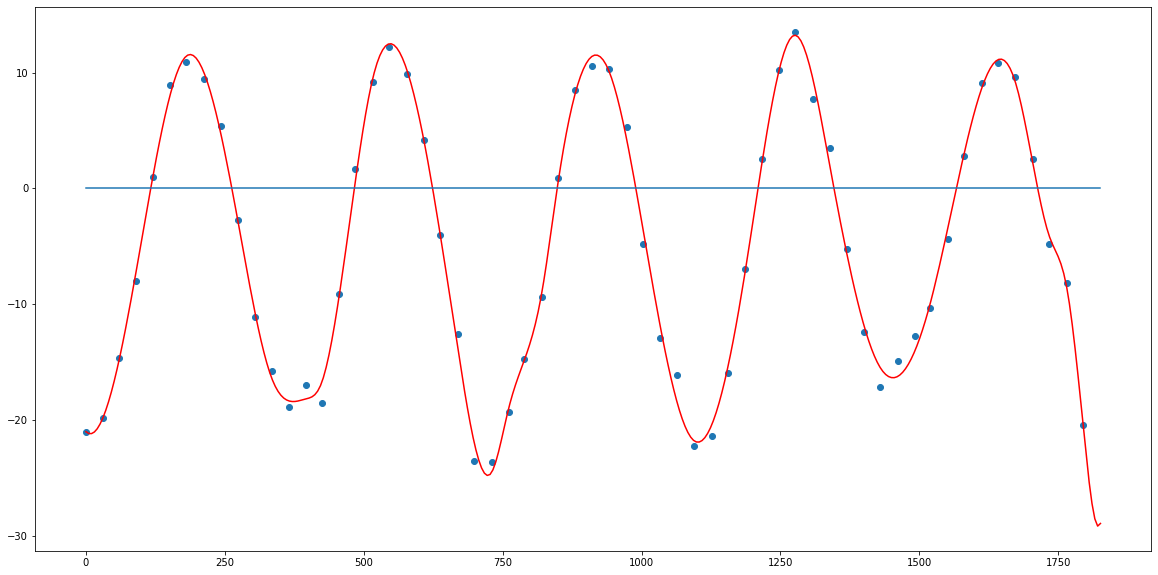

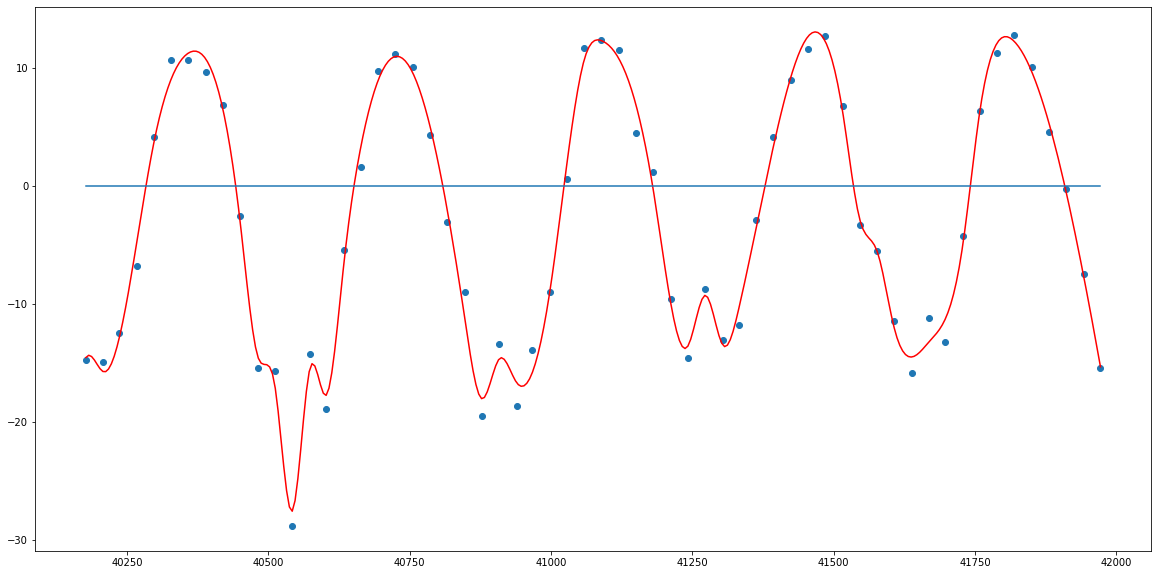

In [47]:
spline

fig, ax = plt.subplots(figsize=[20,10])
ax.scatter(days[:60], ex_temperature[:60])
ls = np.linspace(0, days[60], num=360)
ax.plot(ls, spline(ls), c='r')
ax.plot(ls,ls*0)



fig, ax = plt.subplots(figsize=[20,10])
ax.scatter(days[-60:], ex_temperature[-60:])
ls = np.linspace(days[-60], days[-1], num=360)
ax.plot(ls, spline(ls), c='r')
ax.plot(ls,ls*0)



In [38]:
tdd_n = []
fdd_n = []
for rdx in range(len(spline.roots())-1):
    val = spline.integral(spline.roots()[rdx], spline.roots()[rdx+1])
    print(spline.roots()[rdx], spline.roots()[rdx+1], '=', val)
    if val > 0:
        tdd_n.append(val)
    else:
        fdd_n.append(val)

116.64055535095636 262.64558778758874 = 1075.1099543189996
262.64558778758874 483.0663257972346 = -2805.1743433453476
483.0663257972346 623.957326027217 = 1144.54439106353
623.957326027217 848.1786517180846 = -3257.334009038545
848.1786517180846 989.7595561957004 = 1067.8245630638628
989.7595561957004 1209.6041000709986 = -3008.687483499388
1209.6041000709986 1346.3749292363327 = 1123.4338365671777
1346.3749292363327 1566.6405099986177 = -2304.6779723145864
1566.6405099986177 1712.9970761553675 = 1035.7616224185902
1712.9970761553675 1939.8288533200507 = -2909.4509503297663
1939.8288533200507 2092.8306127289156 = 1130.3728124230927
2092.8306127289156 2302.444173304657 = -2893.5716452881793
2302.444173304657 2448.837700875579 = 1099.295218701527
2448.837700875579 2674.3656932068316 = -2921.610957301157
2674.3656932068316 2804.9648370996597 = 1041.9524760127224
2804.9648370996597 3037.9995742953474 = -3053.4156634926185
3037.9995742953474 3178.2054236250033 = 1060.499012475821
3178.20542

In [45]:
fdd = [fdd[0]] + fdd 
fdd_n = [fdd_n[0]] + fdd_n
print('tdd', len(tdd), tdd[0], tdd_n[0])
print('fdd', len(fdd), fdd[0], fdd[1], fdd_n[0], fdd_n[1])

tdd 115 1075.1099543189996 1075.1099543189996
fdd 116 -2805.1743433453476 -2805.1743433453476 -2805.1743433453476 -2805.1743433453476


In [ ]:

num_processes = 6

missing_elements = calc_grid_degree_days(
    days, 
    temperature_data.grids, 
    tdd_data.grids, 
    fdd_data.grids, 
    grid_shape, 
    num_process = num_processes,
)

115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114
115 114


#### Save  Data

In [ ]:
tdd_out = './tdd'
fdd_out = './fdd'

try:
    os.makedirs(tdd_out)
except IOError:
    pass

try:
    os.makedirs(fdd_out)
except IOError:
    pass

fdd_data.config['raster_metadata'] = raster_metadata
tdd_data.config['raster_metadata'] = raster_metadata

fdd_data.save_all_as_geotiff(fdd_out)
tdd_data.save_all_as_geotiff(tdd_out)

#### View results

In [ ]:
data = gdal.Open(os.path.join('tdd', 'tdd_1902.tif'))
plt.imshow(data.ReadAsArray(), cmap='Reds', vmin=0, vmax=1250)
plt.colorbar()

#### Notes on Resuming Calculations 

If you are worried that the caculations performed here may be interupted you can save the degree-day TemporalGrids before calling `ddc.calc_degree_days.calc_gird_degree_days`, by using the `.save` method. The `.save` method save the Temporal Grid as a `.mgdata` (the data) and `.yml` (the metadata) file Now if the function is intrupeted you can reload the data using `ddc.multigrids.TemporalGrid`.

In [ ]:
# save 
fdd_data.save('fdd.yml') ## pass the metadata name as the save name
tdd_data.save('tdd.yml')

# load

fdd_data = TemporalGrid('fdd.yml') ## load by passing the metadata name
tdd_data = TemporalGrid('tdd.yml')